In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/iris.txt


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

### Reading the data file

In [3]:
df = pd.read_csv(r'/kaggle/input/iris.txt')
df.head()

df = df.iloc[:,:-1]
df.dtypes

5.1    float64
3.5    float64
1.4    float64
0.2    float64
dtype: object

### Min max Scaling the data set to vary between [0,1]

In [4]:
from sklearn.preprocessing import MinMaxScaler
feature_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = feature_scaler.fit_transform(df)
df_scaled = pd.DataFrame(data=df_scaled)
df_scaled.head()

,0,1,2,3
0,0.166667,0.416667,0.067797,0.041667
1,0.083333,0.458333,0.084746,0.041667
2,0.194444,0.666667,0.067797,0.041667
3,0.083333,0.583333,0.067797,0.083333
4,0.194444,0.583333,0.084746,0.041667


## Define parameters for SOM network

In [5]:
som_width = 8
som_length = 8
epochs = 10000
initial_learning_rate=0.01
np.random.seed(10)

In [6]:
raws,cols = df_scaled.shape
print("Data set raw count=%d column count=%d" %(raws, cols))

Data set raw count=149 column count=4


In [7]:
initial_radius = max(som_width, som_length)/2
time_constant =  epochs/np.log(initial_radius)

In [8]:
som_net = np.random.random((som_width, som_length, cols))
print("Initial weights set to SOM network:")
print(som_net)

Initial weights set to SOM network:
[[[0.77132064 0.02075195 0.63364823 0.74880388]
  [0.49850701 0.22479665 0.19806286 0.76053071]
  [0.16911084 0.08833981 0.68535982 0.95339335]
  [0.00394827 0.51219226 0.81262096 0.61252607]
  [0.72175532 0.29187607 0.91777412 0.71457578]
  [0.54254437 0.14217005 0.37334076 0.67413362]
  [0.44183317 0.43401399 0.61776698 0.51313824]
  [0.65039718 0.60103895 0.8052232  0.52164715]]

 [[0.90864888 0.31923609 0.09045935 0.30070006]
  [0.11398436 0.82868133 0.04689632 0.62628715]
  [0.54758616 0.819287   0.19894754 0.8568503 ]
  [0.35165264 0.75464769 0.29596171 0.88393648]
  [0.32551164 0.1650159  0.39252924 0.09346037]
  [0.82110566 0.15115202 0.38411445 0.94426071]
  [0.98762547 0.45630455 0.82612284 0.25137413]
  [0.59737165 0.90283176 0.53455795 0.59020136]]

 [[0.03928177 0.35718176 0.07961309 0.30545992]
  [0.33071931 0.7738303  0.03995921 0.42949218]
  [0.31492687 0.63649114 0.34634715 0.04309736]
  [0.87991517 0.76324059 0.87809664 0.41750914]


### Define basic functions needed to decay learning rate, radius and calculate Euclidian distance

In [9]:
def update_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def update_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

def calculate_euclidian_dis(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

### Logic to calculcate best matching unit

In [10]:
def find_best_matching_Unit(data_point):
    bmu_pos = np.array([0, 0])
    min_dist = np.iinfo(np.int).max
    input_dim = len(data_point)
    
    for x in range(som_width):
        for y in range(som_length):
            som_weight_vector = som_net[x, y, :].reshape(1, 4)
            euclidian_dist = calculate_euclidian_dis(som_weight_vector, data_point)
            if euclidian_dist < min_dist:
                min_dist = euclidian_dist
                bmu_pos = np.array([x, y])
    
    bmu = som_net[bmu_pos[0], bmu_pos[1], :].reshape(1, 4)
    return (bmu, bmu_pos)

### Neighbourhood function to calculate influence from best matching unit and selected node

In [11]:
def neighbourhood_function(bmu_location, selected_node_location, radius):
    euclidien_dist_to_bmu = calculate_euclidian_dis(bmu_location, selected_node_location)
    return np.exp(-euclidien_dist_to_bmu / (2* (radius**2)))

### Train SOM network with Iris data set

In [12]:
#shuffle data set
df_scaled = df_scaled.sample(frac=1)

rad_values = list()
learn_rates_values = list()
rad_values.append(initial_radius)
learn_rates_values.append(initial_learning_rate)

for i in range(epochs):
    data_point = np.array(df_scaled.sample())
    bmu, bmu_idx = find_best_matching_Unit(data_point)

    r_new = update_radius(initial_radius, i, time_constant)
    new_learning_rate = update_learning_rate(initial_learning_rate, i, epochs)
    
    rad_values.append(r_new)
    learn_rates_values.append(new_learning_rate)
    
    for x in range(som_width):
        for y in range(som_length):
            w = som_net[x, y, :].reshape(1, 4)
            w_dist = calculate_euclidian_dis(np.array([x, y]), bmu_idx)
            
            if w_dist <= r_new:
                influence = neighbourhood_function(bmu, w, r_new)
                new_w = w + (new_learning_rate * influence * (data_point - w))
                som_net[x, y, :] = new_w.reshape(1, 4)          

Text(0.5, 1.0, 'Radius values')

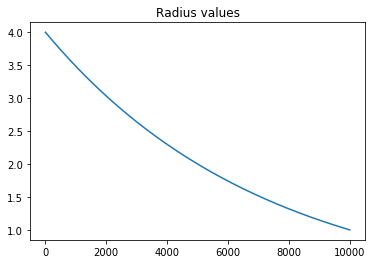

In [14]:
from matplotlib import pyplot as plt
plt.plot(rad_values)
plt.title('Radius values')

Text(0.5, 1.0, 'Learning Rates values')

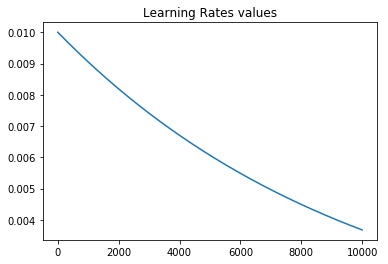

In [15]:
plt.plot(learn_rates_values)
plt.title('Learning Rates values')

### Visualize the weights of the SOM after number of epoch times

In [ ]:
from matplotlib import patches as patches

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1, aspect='equal')
ax.set_xlim((0, som_width+1))
ax.set_ylim((0, som_length+1))
ax.set_title('Self-Organising Map after %d iterations' % epochs)

for x in range(1, som_width + 1):
    for y in range(1, som_length + 1):
        ax.add_patch(patches.Circle((x, y), 0.5, facecolor=som_net[x-1,y-1,:], edgecolor='black'))
plt.show()

fig.savefig('SOM_iris_data.png')

### From above graph, a clear clustering of data can be seen such that same colors in the neighbourhood in a cluster and different cluseters with different colors

### U Matrix Calculation from above SOM

In [ ]:
u_matrix = np.zeros((som_width-1, som_length-1))

for x in range(1, som_width):
    for y in range(1, som_length):
        neighbour_list = list()
        print("-"* 100)
        print("neighbour cordinates of x=%d, y=%d" %(x,y))
        for u in range(x-1, x+2):
            if (u < 0 or u > (som_width-1)):
                continue
            for v in range(y-1, y+2):
                if(v < 0 or v > (som_length-1)):
                    continue
                if (u == x and v == y):
                    continue
                neighbour_list.append(np.array([u,v]))
                print(u,v)
        sum=0
        for idx in neighbour_list:
            sum += calculate_euclidian_dis(som_net[x,y,:], som_net[idx[0],idx[1],:])
        
        avg = sum/len(neighbour_list)
        print("Sum of distance to neighbour weights=%f, average=%f" % (sum, avg))     
        u_matrix[x-1,y-1] = avg

In [ ]:
fig = plt.figure(figsize=(7,7))
plt.title("U Matrix visualization of Iris data using SOM")
plt.imshow(u_matrix, cmap="gray")
plt.show()
fig.savefig('U_Matrix_iris.png')

**In above grayscale image, light colors depict closely spaced node codebook vectors and darker colors indicate more widely separated node codebook vectors. Therefore groups of light colors can be considered as clusters, and the dark parts as the boundaries between the clusters.**